In [1]:
import pandas as pd
import numpy as np
import importlib
import XGModel
importlib.reload(XGModel)
from XGModel import train_xgb_tuned, make_team_ranking_report 

all_shots = pd.read_csv("shots.csv") # original dataset

# Convert shot type to numeric shot value
all_shots["SHOT_VALUE"] = all_shots["SHOT_TYPE"].apply(lambda x: 3 if "3PT" in x else 2)

all_shots = all_shots.drop(columns=[], errors = 'ignore')

# Removing variables which won't be included in the project
# The following are either redundant, unreleated or overcomplicate the interpretability

cols_to_drop = [
    "GRID_TYPE",
    "SHOT_ATTEMPTED_FLAG",
    "PLAYER_ID", "TEAM_ID", "GAME_ID", "GAME_EVENT_ID",
    "EVENT_TYPE", "SHOT_TYPE",
    "GAME_DATE", "HTM","VTM",
    "LOC_X","LOC_Y", "SHOT_DISTANCE",
    "PERIOD", "MINUTES_REMAINING", "SECONDS_REMAINING"
]

# COMBINES THREE SHOT DESCRIPTORS INTO ONE
all_shots_zones_comb = all_shots.copy()
all_shots_zones_comb['SHOT_ZONE'] = all_shots_zones_comb['SHOT_ZONE_BASIC'] + " - " + all_shots_zones_comb['SHOT_ZONE_AREA'] + " - " + all_shots_zones_comb['SHOT_ZONE_RANGE']
all_shots_zones_comb = all_shots_zones_comb.drop(columns=["SHOT_ZONE_BASIC","SHOT_ZONE_AREA","SHOT_ZONE_RANGE"], errors = 'ignore')

# Remove backcourt shots
all_shots_zones_comb = all_shots_zones_comb[~all_shots_zones_comb["SHOT_ZONE"].str.contains("Back Court")]
shots_all = all_shots_zones_comb.copy()

zone_counts = shots_all["SHOT_ZONE"].value_counts()
zone_percent = zone_counts / zone_counts.sum() * 100

# Display Shot Zones
for zone, count in zone_counts.items():
    pct = zone_percent[zone]
    print(f"{zone}: {count}  ({pct:.2f}%)")

Restricted Area - Center(C) - Less Than 8 ft.: 66762  (32.56%)
In The Paint (Non-RA) - Center(C) - Less Than 8 ft.: 19173  (9.35%)
Above the Break 3 - Left Side Center(LC) - 24+ ft.: 16458  (8.03%)
Above the Break 3 - Right Side Center(RC) - 24+ ft.: 15660  (7.64%)
Above the Break 3 - Center(C) - 24+ ft.: 10785  (5.26%)
Mid-Range - Right Side Center(RC) - 16-24 ft.: 8028  (3.92%)
Left Corner 3 - Left Side(L) - 24+ ft.: 7759  (3.78%)
Mid-Range - Left Side Center(LC) - 16-24 ft.: 7635  (3.72%)
Mid-Range - Right Side(R) - 8-16 ft.: 7552  (3.68%)
Mid-Range - Left Side(L) - 8-16 ft.: 7544  (3.68%)
Right Corner 3 - Right Side(R) - 24+ ft.: 7276  (3.55%)
Mid-Range - Center(C) - 16-24 ft.: 7214  (3.52%)
In The Paint (Non-RA) - Center(C) - 8-16 ft.: 6756  (3.29%)
Mid-Range - Left Side(L) - 16-24 ft.: 5383  (2.63%)
Mid-Range - Right Side(R) - 16-24 ft.: 4869  (2.37%)
Mid-Range - Center(C) - 8-16 ft.: 2228  (1.09%)
In The Paint (Non-RA) - Left Side(L) - 8-16 ft.: 2065  (1.01%)
In The Paint (Non-R


LEAGUE 
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Hyperparameters:
{'xgb__subsample': 0.75, 'xgb__n_estimators': 750, 'xgb__max_depth': 12, 'xgb__learning_rate': 0.01, 'xgb__colsample_bytree': 0.5}


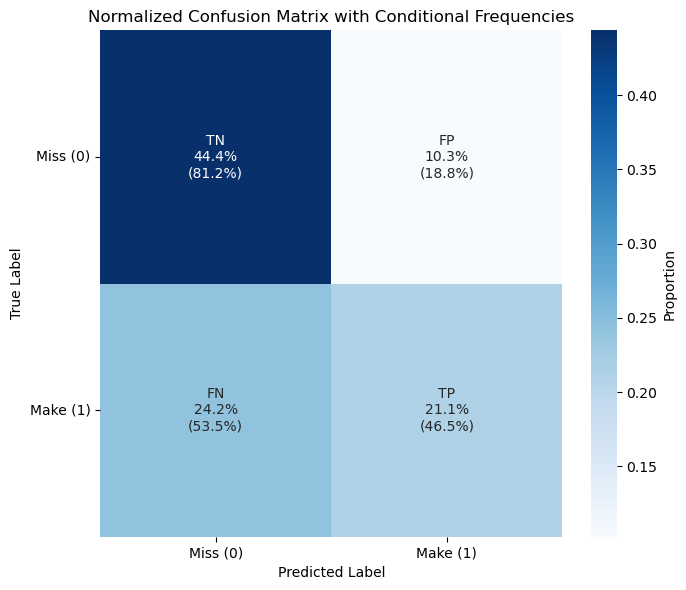


Predicted Overall Shot Success: 0.4546359181
Actual Overall Shot Success: 0.4536100071

Accuracy: 0.655


In [2]:
# --------------------------
# DATA & FEATURES
# --------------------------
features = [
    "PLAYER_NAME", "TEAM_NAME", 
    "ACTION_TYPE", "SHOT_ZONE"
]

target = "SHOT_MADE_FLAG"

# --------------------------
# PARAM GRID (for hyperparameter tuning)
# --------------------------
param_grid = {
    "xgb__n_estimators": [100, 250, 500, 750, 1000],
    "xgb__max_depth": [3, 5, 8, 10, 12],
    "xgb__learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
    "xgb__subsample": [0.5, 0.75, 1.0],
    "xgb__colsample_bytree": [0.5, 0.75, 1.0]
}

print("\nLEAGUE ")

# --------------------------
# Train model on ALL shots 
# --------------------------
(
    best_all,
    X_all_test,
    y_all_test,
    proba_all,
    acc_all,
    pred_all,
    actual_all
) = train_xgb_tuned(
    shots_all, features, target, param_grid
)


WASHINGTON WIZARDS 


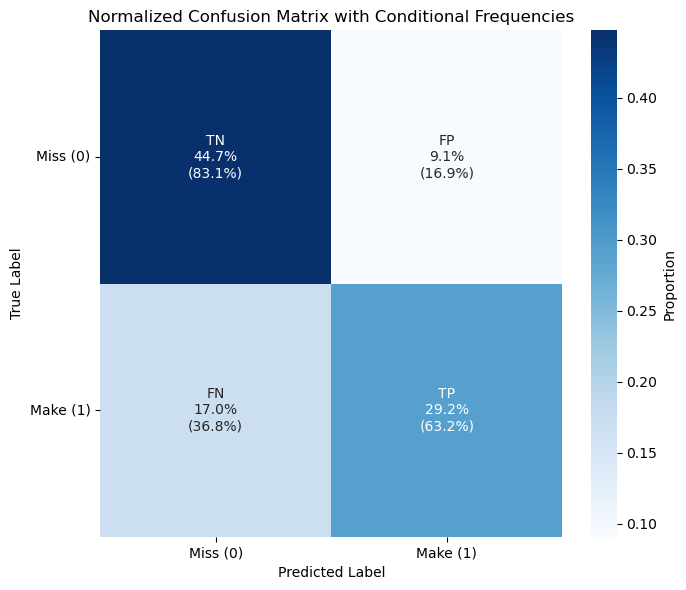


Predicted Overall Shot Success: 0.4731468260
Actual Overall Shot Success: 0.4618291761
Accuracy: 0.739


In [3]:
importlib.reload(XGModel)
from XGModel import league_xgb_tuned #fixed hyper parameters

wiz = shots_all[shots_all["TEAM_NAME"] == "Washington Wizards"].copy()

# --------------------------
# Train model on ALL shots 
# --------------------------
print("\nWASHINGTON WIZARDS ")
(
    wiz_all,
    X_wiz_test,
    y_wiz_test,
    proba_wiz,
    acc_wiz,
    pred_wiz,
    actual_wiz
) = league_xgb_tuned(
    wiz, features, target
)

In [4]:
make_team_ranking_report(shots_all, features=features, model=best_all)


 TEAM ACCURACCY TABLE 
             TEAM_NAME  Accuracy
    Washington Wizards    0.7317
    Philadelphia 76ers    0.7234
    Los Angeles Lakers    0.6909
       Milwaukee Bucks    0.6878
  New Orleans Pelicans    0.6871
 Golden State Warriors    0.6805
        Boston Celtics    0.6717
      Sacramento Kings    0.6644
       Detroit Pistons    0.6630
             Utah Jazz    0.6617
       Houston Rockets    0.6609
Minnesota Timberwolves    0.6602
           LA Clippers    0.6580
     Charlotte Hornets    0.6580
        Denver Nuggets    0.6577
          Phoenix Suns    0.6534
Portland Trail Blazers    0.6529
        Indiana Pacers    0.6492
      Dallas Mavericks    0.6489
            Miami Heat    0.6486
         Chicago Bulls    0.6438
       Toronto Raptors    0.6437
 Oklahoma City Thunder    0.6432
   Cleveland Cavaliers    0.6421
       New York Knicks    0.6401
         Orlando Magic    0.6386
     Memphis Grizzlies    0.6383
         Brooklyn Nets    0.6355
         Atlanta Ha

,TEAM_NAME,Accuracy
28,Washington Wizards,0.7317
4,Philadelphia 76ers,0.7234
27,Los Angeles Lakers,0.6909
16,Milwaukee Bucks,0.6878
15,New Orleans Pelicans,0.6871
3,Golden State Warriors,0.6805
26,Boston Celtics,0.6717
21,Sacramento Kings,0.6644
22,Detroit Pistons,0.6630
18,Utah Jazz,0.6617


In [5]:
# ----------------------------
# Predict probability for shots
# ----------------------------
X_all = shots_all[features]
shots_all["xP_prob"] = best_all.predict_proba(X_all)[:, 1]
shots_all["xP"] = shots_all["xP_prob"] * shots_all["SHOT_VALUE"]
shots_all["y_pred"] = (shots_all["xP_prob"] >= 0.5).astype(int)
shots_all["actual_points"] = shots_all["SHOT_VALUE"] * shots_all["SHOT_MADE_FLAG"]

# ----------------------------
# Filter Wizards
# ----------------------------
wiz = shots_all[shots_all["TEAM_NAME"] == "Washington Wizards"].copy()
shots_all["correct"] = (shots_all["y_pred"] == shots_all["SHOT_MADE_FLAG"]).astype(int)

# ----------------------------
# Group by PLAYER × ZONE × ACTION 
# ----------------------------
player_zone_action = wiz.groupby(
    ["PLAYER_NAME", "SHOT_ZONE", "ACTION_TYPE"]
).agg(
    expected_points_player_zone_action=("xP", "mean"), # expected pts from model
    actual_points_player_zone_action=("actual_points", "mean"), # true avg pts
    prop_correct_player_zone_action=(  # prop correct predictions
        "y_pred", 
        lambda s: np.mean(s == shots_all.loc[s.index, "SHOT_MADE_FLAG"])
    ),
    n_shots_player_zone_action=("SHOT_MADE_FLAG", "count") # number of shots 
).reset_index()

# ----------------------------
# Rearrange columns
# ----------------------------
cols_ordered = [
    # identifiers
    "PLAYER_NAME", "SHOT_ZONE", "ACTION_TYPE",
    
    # shot frequency 
    "n_shots_player_zone_action", 

    # Useful for comparing how many correct predictions our model makes
    "prop_correct_player_zone_action", 

    # expected points
    "expected_points_player_zone_action",  

    # True points 
    "actual_points_player_zone_action"
]

player_zone_action = player_zone_action[cols_ordered]

# ----------------------------
# Filter by sample size to ensure SE < 0.1, where p = true team FG PCT
# Using formula shown in paper
# Keep only rows where the exact shot has been taken 25+ times
# ----------------------------
player_zone_action = player_zone_action.loc[
    player_zone_action["n_shots_player_zone_action"] >= 25
]

# ----------------------------
# Sort by expected points
# ----------------------------
player_zone_action = (
    player_zone_action
    .sort_values(by="expected_points_player_zone_action", ascending=False)
    .reset_index(drop=True)
)


player_zone_action["prop_correct_player_zone_action"] = (player_zone_action["prop_correct_player_zone_action"]
    .mul(100)
    .round(1)
    .astype(str)
    + "%")

# ----------------------------
# Rename Columns
# ----------------------------
player_zone_action = (
    player_zone_action
        .rename(columns={
            "PLAYER_NAME": "Player", 
            "SHOT_ZONE": "Court Zone", 
            "ACTION_TYPE": "Shot Type",
            "actual_points_player_zone_action": "true avg pts",
            "expected_points_player_zone_action": "expected pts",
            "prop_correct_player_zone_action": "% correct predictions"
        })
        .drop(columns={"n_shots_player_zone_action"})
        .sort_values(by="expected pts", ascending=False)
        .reset_index(drop=True)
)
# ----------------------------
# Display / save
# ----------------------------
print("\n===== Wizards Shot Analysis vs League =====")
player_zone_action.to_csv("wiz_full_analysis.csv", index=False)
print(player_zone_action)


===== Wizards Shot Analysis vs League =====
             Player                                         Court Zone  \
0     Marcin Gortat      Restricted Area - Center(C) - Less Than 8 ft.   
1         John Wall      Restricted Area - Center(C) - Less Than 8 ft.   
2     Marcin Gortat      Restricted Area - Center(C) - Less Than 8 ft.   
3    Ramon Sessions      Restricted Area - Center(C) - Less Than 8 ft.   
4      Bradley Beal      Restricted Area - Center(C) - Less Than 8 ft.   
5         John Wall      Restricted Area - Center(C) - Less Than 8 ft.   
6         John Wall      Restricted Area - Center(C) - Less Than 8 ft.   
7         John Wall       Mid-Range - Left Side Center(LC) - 16-24 ft.   
8         John Wall                  Mid-Range - Center(C) - 16-24 ft.   
9         John Wall      Mid-Range - Right Side Center(RC) - 16-24 ft.   
10     Jared Dudley           Right Corner 3 - Right Side(R) - 24+ ft.   
11    Marcin Gortat  In The Paint (Non-RA) - Center(C) - Less Than 

In [6]:
# Isolate 5 starting players in MS Excel

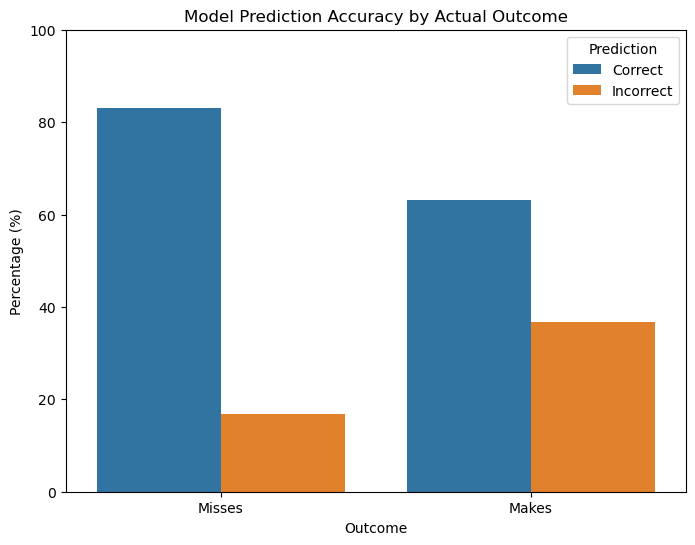

In [7]:
# ----------------------------
# Visualizing Models' predictive ability
# ----------------------------
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data
data = pd.DataFrame({
    "Outcome": ["Misses", "Misses", "Makes", "Makes"],
    "Prediction": ["Correct", "Incorrect", "Correct", "Incorrect"],
    "Percentage": [83.1, 16.9, 63.2, 36.8]
})

plt.figure(figsize=(8,6))
sns.barplot(x="Outcome", y="Percentage", hue="Prediction", data=data)
plt.ylim(0,100)
plt.ylabel("Percentage (%)")
plt.title("Model Prediction Accuracy by Actual Outcome")
plt.show()
